In [1]:
% matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from snntoolbox.datasets.aedat.DVSIterator import DVSIterator, load_event_list, get_frames_from_sequence

Using TensorFlow backend.


In [2]:
path = '/home/rbodo/.snntoolbox/Datasets/predator_prey'
path_aedat = os.path.join(path, 'aedat')
path_aedat_all = os.path.join(path_aedat, 'all')
path_aedat_test = os.path.join(path_aedat, 'not_balanced_4834samples')
path_npz = os.path.join(path, 'npz', 'dvs', 'rectified_sum',
                        'maxpool_subsampling', 'scale_before_clip')
data_format = 'channels_last'
eventframe_width = 10
num_dvs_events_per_sample = 5000
chip_size = [240, 180]
image_shape = [36, 36]
batch_shape = [1] + image_shape + [1] if data_format == 'channels_last' else [1, 1] + image_shape
label_dict = {"N": "0", "L": "1", "C": "2", "R": "3",}
frame_gen_method = 'rectified_sum'
is_x_first = True
is_x_flipped = True
is_y_flipped = True
maxpool_subsampling = True
do_clip_three_sigma = True

In [3]:
filenames_x = [
    'DAVIS240C-2016-01-11T15-43-32+0000-04010058-0_recording_1.aedat',
    'DAVIS240C-2016-01-11T15-50-11+0000-04010058-0_recording_2.aedat',
    'DAVIS240C-2016-01-11T15-53-42+0000-04010058-0_recording_3.aedat',
    'DAVIS240C-2016-01-11T15-57-58+0000-04010058-0_recording_4.aedat',
    'DAVIS240C-2016-01-11T16-00-00+0000-04010058-0_recording_5.aedat',
    'DAVIS240C-2016-01-15T10-39-15+0000-04010058-0_recording_7.aedat',
    'DAVIS240C-2016-02-23T12-42-14+0000-04010058-0_recording_8.aedat',
    'DAVIS240C-2016-02-23T12-44-25+0000-04010058-0_recording_9.aedat',
    'DAVIS240C-2016-02-23T13-03-56+0000-04010058-0_recording_10.aedat',
    'DAVIS240C-2016-02-23T13-39-29+0000-04010058-0_recording_11.aedat',
    'DAVIS240C-2016-02-23T13-42-36+0000-04010058-0_recording_12.aedat',
    'DAVIS240C-2016-02-23T13-48-36+0000-04010058-0_recording_13.aedat',
    'DAVIS240C-2016-02-23T14-04-37+0000-04010058-0_recording_14.aedat',
    'DAVIS240C-2016-02-26T10-14-49+0000-04010058-0_recording_16.aedat',
    'DAVIS240C-2016-02-26T10-19-37+0000-04010058-0_recording_17.aedat',
    'DAVIS240C-2016-02-26T10-22-32+0000-04010058-0_recording_18.aedat']

filenames_y = [
    'DAVIS240C-2016-01-11T15-43-32+0000-04010058-0_recording_1-targets.txt',
    'DAVIS240C-2016-01-11T15-50-11+0000-04010058-0_recording_2-targets.txt',
    'DAVIS240C-2016-01-11T15-53-42+0000-04010058-0_recording_3-targets.txt',
    'DAVIS240C-2016-01-11T15-57-58+0000-04010058-0_recording_4-targets.txt',
    'DAVIS240C-2016-01-11T16-00-00+0000-04010058-0_recording_5-targets.txt',
    'DAVIS240C-2016-01-15T10-39-15+0000-04010058-0_recording_7-targets.txt',
    'DAVIS240C-2016-02-23T12-42-14+0000-04010058-0_recording_8-targets.txt',
    'DAVIS240C-2016-02-23T12-44-25+0000-04010058-0_recording_9-targets.txt',
    'DAVIS240C-2016-02-23T13-03-56+0000-04010058-0_recording_10-targets.txt',
    'DAVIS240C-2016-02-23T13-39-29+0000-04010058-0_recording_11-targets.txt',
    'DAVIS240C-2016-02-23T13-42-36+0000-04010058-0_recording_12-targets.txt',
    'DAVIS240C-2016-02-23T13-48-36+0000-04010058-0_recording_13-targets.txt',
    'DAVIS240C-2016-02-23T14-04-37+0000-04010058-0_recording_14-targets.txt',
    'DAVIS240C-2016-02-26T10-14-49+0000-04010058-0_recording_16-targets.txt',
    'DAVIS240C-2016-02-26T10-19-37+0000-04010058-0_recording_17-targets.txt',
    'DAVIS240C-2016-02-26T10-22-32+0000-04010058-0_recording_18-targets.txt']


In [4]:
def get_y(filepath, start_times):
    
    label_file = open(filepath)
    labels_list = []
    times_list = []
    lines = label_file.readlines()
    
    for line in lines:
        line_segments = line.split()
        if line_segments[0] == '#':
            continue
        t = int(line_segments[1])
        x_coord = int(line_segments[2])

        if x_coord == -1:
            label = 0  # N
        elif x_coord < 80:
            label = 1  # L
        elif x_coord < 160:
            label = 2  # C
        elif x_coord < 240:
            label = 3  # R
        else:
            label = 4  # Invalid
        labels_list.append(label)
        times_list.append(t)
    
    labels_array = np.array(labels_list)
    times_array = np.array(times_list)
    y = [labels_array[np.argmin(np.abs(times_array - st))] for st in start_times]

    return np.array(y)

In [5]:
x_new = None
y_new = None
i = 0
for filename_x, filename_y in zip(filenames_x, filenames_y):
    filepath_x = os.path.join(path_aedat_all, filename_x)
    filepath_y = os.path.join(path_aedat_all, filename_y)
     
    event_sequence = load_event_list(filepath_x)
    
    num_frames = int(len(event_sequence) / num_dvs_events_per_sample)

    x = get_frames_from_sequence(
        event_sequence, num_dvs_events_per_sample, data_format, frame_gen_method, 
        is_x_first, is_x_flipped, is_y_flipped, maxpool_subsampling, 
        do_clip_three_sigma, chip_size, image_shape)

    timestamps = [e[2] for e in event_sequence]

    start_times_ = timestamps[::num_dvs_events_per_sample]
    start_times = start_times_[:-1]
    y_ = get_y(filepath_y, start_times)
    y = to_categorical(y_, 4)
    
    assert len(x) == len(y) == num_frames, 'x: {}, y: {}, num_frames: {}'.format(
        len(x), len(y), num_frames)

    # Have to reload because keeping the whole list of x's in memory causes segmentation faults.
    if i == 0:
        x_new = x
        y_new = y
    else:
        x_prev = np.load(os.path.join(path_npz, 'x_{}.npz'.format(i-1)))['arr_0']
        y_prev = np.load(os.path.join(path_npz, 'y_{}.npz'.format(i-1)))['arr_0']
        x_new = np.concatenate([x_prev, x])
        y_new = np.concatenate([y_prev, y])
    
    np.savez_compressed(os.path.join(path_npz, 'x_{}'.format(i)), x_new)
    np.savez_compressed(os.path.join(path_npz, 'y_{}'.format(i)), y_new)
    
    i += 1

x_all = x_new
y_all = y_new

np.savez_compressed(os.path.join(path_npz, 'x_all'), x_all)
np.savez_compressed(os.path.join(path_npz, 'y_all'), y_all)


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-11T15-43-32+0000-04010058-0_recording_1.aedat...


Extracting 15864 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-11T15-50-11+0000-04010058-0_recording_2.aedat...


Extracting 13492 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-11T15-53-42+0000-04010058-0_recording_3.aedat...


Extracting 30473 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-11T15-57-58+0000-04010058-0_recording_4.aedat...


Extracting 10950 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-11T16-00-00+0000-04010058-0_recording_5.aedat...


Extracting 4094 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-01-15T10-39-15+0000-04010058-0_recording_7.aedat...


Extracting 24495 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T12-42-14+0000-04010058-0_recording_8.aedat...


Extracting 5327 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T12-44-25+0000-04010058-0_recording_9.aedat...


Extracting 15681 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T13-03-56+0000-04010058-0_recording_10.aedat...


Extracting 17501 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T13-39-29+0000-04010058-0_recording_11.aedat...


Extracting 9694 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T13-42-36+0000-04010058-0_recording_12.aedat...


Extracting 11077 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T13-48-36+0000-04010058-0_recording_13.aedat...


Extracting 10266 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-23T14-04-37+0000-04010058-0_recording_14.aedat...


Extracting 20830 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-26T10-14-49+0000-04010058-0_recording_16.aedat...


Extracting 21009 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-26T10-19-37+0000-04010058-0_recording_17.aedat...


Extracting 6982 frames from DVS event sequence.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/all/DAVIS240C-2016-02-26T10-22-32+0000-04010058-0_recording_18.aedat...


Extracting 12643 frames from DVS event sequence.


### Split train / test set

In [7]:
fraction_testset = 0.1
num_samples_total = len(x_all)
num_samples_testset = int(num_samples_total * fraction_testset)

shuffled_idxs = np.random.permutation(num_samples_total)

x_all_shuffled = x_all[shuffled_idxs]
y_all_shuffled = y_all[shuffled_idxs]

np.savez_compressed(os.path.join(path_npz, 'x_all_shuffled'), x_all_shuffled)
np.savez_compressed(os.path.join(path_npz, 'y_all_shuffled'), y_all_shuffled)

x_train = x_all_shuffled[:-num_samples_testset]
y_train = y_all_shuffled[:-num_samples_testset]
x_test = x_all_shuffled[-num_samples_testset:]
y_test = y_all_shuffled[-num_samples_testset:]

np.savez_compressed(os.path.join(path_npz, 'x_train'), x_train)
np.savez_compressed(os.path.join(path_npz, 'y_train'), y_train)
np.savez_compressed(os.path.join(path_npz, 'x_test'), x_test)
np.savez_compressed(os.path.join(path_npz, 'y_test'), y_test)


In [8]:
dvs_gen = DVSIterator(path_aedat_test, batch_shape, data_format, frame_gen_method, 
                      is_x_first, is_x_flipped, is_y_flipped, eventframe_width, 
                      num_dvs_events_per_sample, maxpool_subsampling, do_clip_three_sigma,
                      chip_size, image_shape, label_dict)

Found 65 samples belonging to 4 classes.


In [9]:
x_list = []
y_list = [] 
while True:
    try:
        dvs_gen.next_sequence_batch()
        x_list.append(dvs_gen.get_frame_batch())
        y_list.append(dvs_gen.y_b)
    except StopIteration:
        break

Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_1.aedat...


Total number of events of this sample: 665000.
Number of batches: 133.
Extracting 133 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1524 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 431 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 871 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 247 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 964 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1597 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1174 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 316 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 224 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 154 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 335 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 342 events during subsampling.
Discarded 168 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 173 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 119 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.


Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1351 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 805 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.


Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.


Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 549 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 329 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 757 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 135 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 253 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 371 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2366 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1668 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 246 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 375 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2041 events during subsampling.
Discarded 131 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 657 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 422 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2244 events during subsampling.
Discarded 103 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 391 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 818 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 553 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 527 events during subsampling.
Discarded 713 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 540 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 409 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 42 events during subsampling.
Discarded 642 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 95 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 672 events during subsampling.
Discarded 434 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 155 events during subsampling.
Discarded 340 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 778 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 709 events during subsampling.
Discarded 447 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 776 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 175 events during subsampling.
Discarded 567 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 613 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 618 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1116 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 672 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1408 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 274 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 908 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 409 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1924 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 365 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 538 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 274 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 440 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 508 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 871 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2349 events during subsampling.
Discarded 108 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1136 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 379 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1552 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 478 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_10.aedat...


Total number of events of this sample: 120000.
Number of batches: 24.
Extracting 24 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1664 events during subsampling.


Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 727 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 52 events during subsampling.
Discarded 476 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1602 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 352 events during subsampling.
Discarded 415 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 120 events during subsampling.


Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1479 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 606 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 240 events during subsampling.
Discarded 515 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 221 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 849 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 372 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 521 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 222 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 246 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 236 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 27 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_11.aedat...
Total number of events of this sample: 145000.
Number of batches: 29.
Extracting 29 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1414 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 611 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 188 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 632 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 220 events during subsampling.


Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 632 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2034 events during subsampling.
Discarded 132 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 625 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 132 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 650 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 255 events during subsampling.
Discarded 445 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 453 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 542 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 505 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 319 events during subsampling.
Discarded 428 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 162 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 637 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 82 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 43 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 493 events during subsampling.
Discarded 285 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 18 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_12.aedat...
Total number of events of this sample: 85000.
Number of batches: 17.
Extracting 17 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 805 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 640 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1233 events during subsampling.


Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 61 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 66 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 13 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 58 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 120 events during subsampling.
Discarded 390 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 122 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 226 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_13.aedat...
Total number of events of this sample: 150000.
Number of batches: 30.
Extracting 30 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 456 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 629 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1523 events during subsampling.
Discarded 187 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 147 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 122 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 927 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 205 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 259 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 324 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1250 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1392 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 82 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 89 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1285 events during subsampling.
Discarded 193 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 292 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1092 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 635 events during subsampling.
Discarded 355 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 677 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_14.aedat...


Total number of events of this sample: 85000.
Number of batches: 17.
Extracting 17 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 673 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 25 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 632 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 521 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 296 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1438 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 108 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 294 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1644 events during subsampling.
Discarded 144 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1570 events during subsampling.
Discarded 163 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 267 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 159 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 588 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 329 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_15.aedat...
Total number of events of this sample: 120000.
Number of batches: 24.
Extracting 24 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 850 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 579 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1082 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1280 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1146 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 550 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 964 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 247 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 918 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 409 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 793 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1012 events during subsampling.
Discarded 157 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 3 events during subsampling.
Discarded 208 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 732 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 779 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 696 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_16.aedat...


Total number of events of this sample: 260000.
Number of batches: 52.
Extracting 52 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 575 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1422 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1161 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 415 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 686 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 488 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 857 events during subsampling.
Discarded 213 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 958 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1781 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 288 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1802 events during subsampling.
Discarded 133 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1589 events during subsampling.
Discarded 163 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 267 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 12 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1245 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 432 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 940 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 648 events during subsampling.
Discarded 542 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 944 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 896 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1088 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1549 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 652 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 786 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 966 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 832 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1065 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 952 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 726 events during subsampling.
Discarded 478 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 311 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 972 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1497 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 238 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 733 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 677 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 693 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 990 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1010 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1090 events during subsampling.
Discarded 350 events during 3-sigma standardization.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_18.aedat...
Total number of events of this sample: 165000.
Number of batches: 33.
Extracting 33 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1457 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 696 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 551 events during subsampling.
Discarded 358 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 758 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1052 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 695 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1551 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1056 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1510 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 835 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1248 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 924 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 878 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 205 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 422 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 634 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 865 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1093 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 697 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 184 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1172 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 460 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 700 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1570 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 930 events during subsampling.
Discarded 148 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1075 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_2.aedat...


Total number of events of this sample: 375000.
Number of batches: 75.
Extracting 75 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.


Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 403 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1309 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 540 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 340 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 354 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 358 events during subsampling.
Discarded 241 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.


Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2118 events during subsampling.
Discarded 152 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.


Discarded 418 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 913 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 650 events during subsampling.
Discarded 224 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2245 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 670 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1497 events during subsampling.
Discarded 243 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 520 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 166 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 283 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 342 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 375 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1097 events during subsampling.


Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 342 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 438 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 439 events during subsampling.
Discarded 137 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 646 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 738 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1483 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1948 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 13 events during subsampling.
Discarded 412 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 435 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 230 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 721 events during subsampling.
Discarded 202 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1743 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 158 events during subsampling.
Discarded 388 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1446 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 515 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_3.aedat...


Total number of events of this sample: 740000.
Number of batches: 148.
Extracting 148 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 48 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 68 events during subsampling.
Discarded 415 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 892 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 151 events during subsampling.
Discarded 539 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1146 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 480 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 143 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 831 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 886 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 312 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 534 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 559 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 197 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1175 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2183 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 511 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1120 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 819 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 356 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2177 events during subsampling.
Discarded 145 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 648 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 891 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 604 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 542 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 603 events during subsampling.
Discarded 160 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 543 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 488 events during subsampling.
Discarded 156 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 220 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2106 events during subsampling.
Discarded 170 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 403 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1444 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1350 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 426 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.


Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 209 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 117 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 616 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 357 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 406 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 849 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 366 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 530 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1168 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 252 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1230 events during subsampling.


Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 513 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 498 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 371 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1771 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.


Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 579 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 636 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 560 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1874 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 603 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 175 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1710 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 564 events during subsampling.
Discarded 158 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 181 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 161 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1413 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 431 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 458 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2251 events during subsampling.
Discarded 109 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_4.aedat...


Total number of events of this sample: 345000.
Number of batches: 69.
Extracting 69 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 909 events during subsampling.
Discarded 458 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 930 events during subsampling.


Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.
Discarded 162 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1891 events during subsampling.


Discarded 138 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1189 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 770 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.


Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 423 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1162 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 890 events during subsampling.
Discarded 362 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 615 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 619 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1503 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2092 events during subsampling.
Discarded 125 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequ

Discarded 417 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 815 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 586 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 853 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 13 events during subsampling.
Discarded 487 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1986 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 909 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1454 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 280 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1384 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 369 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1273 events during subsampling.
Discarded 166 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 511 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 496 events during subsampling.


Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_5.aedat...


Total number of events of this sample: 65000.
Number of batches: 13.
Extracting 13 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 720 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 199 events during subsampling.


Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 81 events during subsampling.
Discarded 1414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 84 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 100 events during subsampling.
Discarded 1761 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 423 events during subsampling.
Discarded 192 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1558 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1540 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_6.aedat...
Total number of events of this sample: 65000.
Number of batches: 13.
Extracting 13 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 92 events during subsampling.
Discarded 628 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 349 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 338 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2316 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 335 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 51 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1437 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_8.aedat...


Total number of events of this sample: 445000.
Number of batches: 89.
Extracting 89 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1197 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.


Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 159 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 211 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 720 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2136 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 352 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 352 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 208 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 291 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1726 events during subsampling.
Discarded 192 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1924 events during subsampling.
Discarded 141 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 427 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 178 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 250 events during subsampling.


Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1500 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1336 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 410 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 327 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 342 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 995 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 728 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.


Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 110 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1769 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 458 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 243 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1116 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1682 events during subsampling.
Discarded 177 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1436 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 297 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 245 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 351 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 623 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 213 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 392 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 293 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 217 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 73 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 298 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 186 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 279 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1588 events during subsampling.
Discarded 166 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 332 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 684 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 226 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 440 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1627 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 380 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 186 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 362 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 216 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/C/rec_9.aedat...
Total number of events of this sample: 370000.
Number of batches: 74.
Extracting 74 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 149 events during subsampling.
Discarded 2387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 112 events during subsampling.
Discarded 2325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 2451 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 496 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 758 events during subsampling.


Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 671 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1049 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 901 events during subsampling.
Discarded 153 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 743 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 500 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 565 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 261 events during subsampling.
Discarded 144 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1089 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1030 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 175 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 250 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 206 events during subsampling.
Discarded 607 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 898 events during subsampling.
Discarded 278 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 89 events during subsampling.
Discarded 516 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1197 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 679 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 259 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1169 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 861 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 647 events during subsampling.
Discarded 342 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 796 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 153 events during subsampling.
Discarded 521 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 186 events during subsampling.
Discarded 1084 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 244 events during subsampling.
Discarded 852 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 259 events during subsampling.
Discarded 1201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 158 events during subsampling.
Discarded 573 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 173 events during subsampling.
Discarded 525 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 128 events during subsampling.
Discarded 434 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 162 events during subsampling.
Discarded 547 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 125 events during subsampling.
Discarded 469 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 984 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 694 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 162 events during subsampling.
Discarded 611 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 127 events during subsampling.
Discarded 793 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 380 events during subsampling.
Discarded 955 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 172 events during subsampling.
Discarded 592 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 249 events during subsampling.
Discarded 870 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 274 events during subsampling.
Discarded 1781 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 165 events during subsampling.
Discarded 705 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 178 events during subsampling.
Discarded 595 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 145 events during subsampling.
Discarded 591 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 695 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 640 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 153 events during subsampling.
Discarded 483 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 324 events during subsampling.
Discarded 766 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 713 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 538 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 289 events during subsampling.
Discarded 422 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1517 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 776 events during subsampling.
Discarded 403 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 882 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1123 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 474 events during subsampling.
Discarded 1454 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 832 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 659 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_1.aedat...


Total number of events of this sample: 485000.
Number of batches: 97.
Extracting 97 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1477 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 198 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 320 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 424 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 363 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 300 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 564 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1673 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 459 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1125 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 457 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2080 events during subsampling.
Discarded 136 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 303 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 403 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 380 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.


Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 110 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1325 events during subsampling.


Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 345 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1832 events during subsampling.
Discarded 134 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1219 events during subsampling.
Discarded 163 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 809 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1192 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1324 events during subsampling.


Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 976 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1644 events during subsampling.
Discarded 161 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 515 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 120 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1027 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 550 events during subsampling.


Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2088 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 490 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 440 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.


Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1354 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 342 events during subsampling.
Discarded 256 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 170 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 287 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2135 events during subsampling.
Discarded 119 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 347 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 461 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 569 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1002 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1092 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.


Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 204 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1290 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 621 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 248 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 17 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 852 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_10.aedat...


Total number of events of this sample: 185000.
Number of batches: 37.
Extracting 37 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 399 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 12 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 123 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1318 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 561 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 242 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1709 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2220 events during subsampling.
Discarded 155 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 171 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 715 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1558 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1997 events during subsampling.
Discarded 126 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 478 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.


Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 17 events during subsampling.
Discarded 373 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 716 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 363 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 184 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 274 events during subsampling.
Discarded 389 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 324 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 192 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 553 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 128 events during subsampling.
Discarded 282 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 100 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 713 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 163 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 140 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2 events during subsampling.
Discarded 312 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_11.aedat...
Total number of events of this sample: 80000.
Number of batches: 16.
Extracting 16 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 12 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 197 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 160 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 667 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 167 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 525 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 193 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 900 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 37 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_12.aedat...
Total number of events of this sample: 20000.
Number of batches: 4.
Extracting 4 frames from DVS event sequence.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.


Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 21 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_13.aedat...
Total number of events of this sample: 150000.
Number of batches: 30.
Extracting 30 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1698 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 246 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 588 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 172 events during subsampling.


Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 112 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 23 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 155 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 239 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 198 events during subsampling.


Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 148 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1431 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 653 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 221 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 334 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 380 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 214 events during subsampling.
Discarded 396 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 258 events during subsampling.
Discarded 375 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 417 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 472 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 477 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 377 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 688 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 532 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 106 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_14.aedat...


Total number of events of this sample: 190000.
Number of batches: 38.
Extracting 38 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 237 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 63 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 201 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 235 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 915 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 425 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 505 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 271 events during subsampling.
Discarded 451 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 375 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1564 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 515 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 533 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1975 events during subsampling.
Discarded 139 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2538 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 589 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 505 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 565 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 10 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1420 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 16 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 5 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 673 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_15.aedat...
Total number of events of this sample: 105000.
Number of batches: 21.
Extracting 21 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1453 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1110 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 22 events during subsampling.
Discarded 200 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1437 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 784 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 547 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1366 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 817 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 478 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1851 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1369 events during subsampling.
Discarded 152 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_16.aedat...


Total number of events of this sample: 320000.
Number of batches: 64.
Extracting 64 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 571 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 747 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1225 events during subsampling.


Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 554 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 495 events during subsampling.
Discarded 472 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 492 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 583 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 681 events during subsampling.


Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 750 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 771 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 696 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 953 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 398 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 982 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 774 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 403 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 226 events during subsampling.
Discarded 453 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 460 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 167 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1423 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 660 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 617 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 674 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 176 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 971 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1196 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 188 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 822 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 613 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 394 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 934 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1205 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 150 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 709 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 794 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 153 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 112 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 3 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 211 events during subsampling.
Discarded 520 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1045 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 598 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 793 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 656 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 710 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 530 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1056 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 744 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1097 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 805 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 687 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_18.aedat...
Total number of events of this sample: 85000.
Number of batches: 17.


Extracting 17 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 839 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1472 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 587 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 864 events during subsampling.
Discarded 257 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1229 events during subsampling.
Discarded 150 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2263 events during subsampling.
Discarded 104 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 504 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 628 events during subsampling.
Discarded 150 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS seque

Discarded 506 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 604 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_2.aedat...


Total number of events of this sample: 290000.
Number of batches: 58.
Extracting 58 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 16 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 132 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 705 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1302 events during subsampling.


Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 550 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 594 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 406 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1086 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1142 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.


Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1061 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 688 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 217 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 594 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 662 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 368 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 990 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1727 events during subsampling.
Discarded 138 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 403 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 473 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.


Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2148 events during subsampling.
Discarded 118 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1833 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 434 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 358 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 417 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_3.aedat...


Total number of events of this sample: 420000.
Number of batches: 84.
Extracting 84 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 245 events during subsampling.
Discarded 501 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 291 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 490 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1674 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 434 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 491 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 155 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 350 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1760 events during subsampling.
Discarded 147 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.


Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 241 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 181 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2006 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.


Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 458 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 363 events during subsampling.
Discarded 222 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 371 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 335 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1283 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 879 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 168 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 656 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 385 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2181 events during subsampling.
Discarded 143 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 432 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 552 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1333 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 252 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1049 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1471 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 631 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1283 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 386 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2174 events during subsampling.
Discarded 170 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 347 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 440 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1059 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 16 events during subsampling.
Discarded 447 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 106 events during subsampling.


Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 432 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_4.aedat...
Total number of events of this sample: 150000.
Number of batches: 30.
Extracting 30 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.


Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 587 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2072 events during subsampling.
Discarded 159 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 271 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 630 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 515 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 544 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 450 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 518 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 347 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1181 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 383 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_5.aedat...


Total number of events of this sample: 135000.
Number of batches: 27.
Extracting 27 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 220 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 338 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1478 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 119 events during subsampling.
Discarded 618 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 494 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1098 events during subsampling.


Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 511 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 365 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 281 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 595 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 483 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 588 events during subsampling.
Discarded 165 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 503 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_6.aedat...
Total number of events of this sample: 20000.
Number of batches: 4.
Extracting 4 frames from DVS event sequence.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1687 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 242 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 622 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_8.aedat...
Total number of events of this sample: 55000.
Number of batches: 11.
Extracting 11 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 225 events during subsampling.


Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 963 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1675 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 173 events during subsampling.
Discarded 407 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.


Discarded 221 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/L/rec_9.aedat...
Total number of events of this sample: 140000.
Number of batches: 28.
Extracting 28 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 130 events during subsampling.
Discarded 145 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 247 events during subsampling.
Discarded 121 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 128 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 755 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 975 events during subsampling.


Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1594 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 234 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 277 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 140 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 661 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 312 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 466 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1007 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 300 events during subsampling.
Discarded 1021 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 197 events during subsampling.
Discarded 901 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 236 events during subsampling.
Discarded 792 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 472 events during subsampling.
Discarded 570 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 775 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1061 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1148 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 276 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 700 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1254 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1109 events during subsampling.


Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_1.aedat...
Total number of events of this sample: 35000.
Number of batches: 7.
Extracting 7 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 141 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1635 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1843 events during subsampling.
Discarded 138 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_10.aedat...


Total number of events of this sample: 1180000.
Number of batches: 236.
Extracting 236 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 182 events during subsampling.
Discarded 453 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 426 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 628 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 104 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 513 events during subsampling.
Discarded 358 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 592 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 291 events during subsampling.
Discarded 277 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 86 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 210 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 352 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 48 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 82 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 38 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 560 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 132 events during subsampling.
Discarded 338 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 100 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 48 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 27 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 157 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 99 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 45 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 51 events during subsampling.


Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 97 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 81 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 68 events during subsampling.
Discarded 390 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 693 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1763 events during subsampling.
Discarded 143 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2016 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 98 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 246 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 206 events during subsampling.
Discarded 575 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 256 events during subsampling.
Discarded 377 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 301 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 416 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 340 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 37 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 264 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 217 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 312 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1251 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 549 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 67 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 232 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 520 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 313 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 70 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 103 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 270 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 376 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1134 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 136 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 29 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 91 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 14 events during subsampling.
Discarded 420 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 98 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 141 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 340 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 460 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 106 events during subsampling.
Discarded 424 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 151 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 130 events during subsampling.
Discarded 406 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 374 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 172 events during subsampling.
Discarded 398 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 34 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 13 events during subsampling.
Discarded 455 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 232 events during subsampling.
Discarded 389 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 540 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 54 events during subsampling.
Discarded 399 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 404 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 419 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 269 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 450 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 86 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 491 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 56 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 312 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 538 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 456 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 18 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 165 events during subsampling.
Discarded 449 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 187 events during subsampling.
Discarded 428 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 335 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 215 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 437 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 248 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 307 events during subsampling.
Discarded 472 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 267 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 436 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 490 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 196 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 214 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 335 events during subsampling.
Discarded 258 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1339 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1144 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 21 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 683 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1485 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 136 events during subsampling.
Discarded 358 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 108 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 357 events during subsampling.
Discarded 540 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 475 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 295 events during subsampling.
Discarded 436 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 497 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 283 events during subsampling.
Discarded 596 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 416 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 525 events during subsampling.


Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1376 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 590 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1026 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 551 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 858 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 568 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 320 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 38 events during subsampling.
Discarded 461 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 421 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 111 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 146 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 413 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 23 events during subsampling.
Discarded 418 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 103 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 570 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 184 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 3 events during subsampling.
Discarded 361 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 396 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 648 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 69 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 156 events during subsampling.
Discarded 385 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 199 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 170 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 663 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 42 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 510 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 558 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 358 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 284 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 746 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 107 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 147 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 636 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 193 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 438 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 58 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 288 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 663 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 68 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 143 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1391 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 577 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 496 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 170 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 474 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 693 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 128 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 0 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 103 events during subsampling.
Discarded 333 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 648 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 237 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 305 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 47 events during subsampling.
Discarded 303 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 95 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_11.aedat...


Total number of events of this sample: 530000.
Number of batches: 106.
Extracting 106 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 195 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 258 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 81 events during subsampling.


Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 567 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 94 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 287 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 496 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 502 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 115 events during subsampling.
Discarded 282 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 668 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 983 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 37 events during subsampling.
Discarded 358 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 279 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 54 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 27 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 277 events during subsampling.
Discarded 387 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 79 events during subsampling.
Discarded 415 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 620 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 121 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 40 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1434 events during subsampling.


Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 92 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 220 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 23 events during subsampling.
Discarded 422 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 5 events during subsampling.
Discarded 443 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 620 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 585 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 570 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 521 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 267 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2321 events during subsampling.
Discarded 96 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 567 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1901 events during subsampling.
Discarded 199 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 579 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 608 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1769 events during subsampling.
Discarded 144 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1320 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 520 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 506 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 9 events during subsampling.
Discarded 410 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 12 events during subsampling.
Discarded 411 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 207 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 23 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 407 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 127 events during subsampling.
Discarded 335 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 283 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 83 events during subsampling.
Discarded 407 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1146 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 533 events during subsampling.
Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 266 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 44 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 136 events during subsampling.
Discarded 387 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 141 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 277 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 415 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 92 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 594 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 648 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 597 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.


Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 778 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 22 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 33 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 380 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1628 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 76 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 225 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 299 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 518 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 521 events during subsampling.
Discarded 442 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_12.aedat...


Total number of events of this sample: 670000.
Number of batches: 134.
Extracting 134 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 94 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 567 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 196 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 33 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 597 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1546 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 411 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1411 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 213 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 102 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 417 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 147 events during subsampling.
Discarded 411 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 605 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 603 events during subsampling.
Discarded 388 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 559 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 26 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 398 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 340 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 226 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 323 events during subsampling.
Discarded 358 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 372 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 113 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 127 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 424 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 217 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 467 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 469 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 117 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 585 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 193 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 435 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 41 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 904 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.


Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 261 events during subsampling.
Discarded 402 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 118 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 193 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1413 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 518 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 218 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 692 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 79 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 754 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 248 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 732 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 874 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 270 events during subsampling.
Discarded 394 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 282 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 445 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 195 events during subsampling.
Discarded 481 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 210 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 151 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 611 events during subsampling.
Discarded 283 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 38 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 36 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 26 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 616 events during subsampling.
Discarded 241 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 135 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 129 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 597 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 569 events during subsampling.


Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 160 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1580 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 174 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 3 events during subsampling.
Discarded 376 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 65 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 701 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 524 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 299 events during subsampling.
Discarded 402 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 448 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1168 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 12 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1572 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 167 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 176 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 242 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 338 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 867 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 83 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 113 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 285 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 28 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 83 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 540 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 734 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 500 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 114 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 293 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_13.aedat...


Total number of events of this sample: 540000.
Number of batches: 108.
Extracting 108 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 58 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 265 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 185 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 154 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 133 events during subsampling.
Discarded 410 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 114 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 387 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 198 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 266 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 72 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 405 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 78 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 556 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 93 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.


Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 71 events during subsampling.
Discarded 444 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 550 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 191 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 421 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 605 events during subsampling.


Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 22 events during subsampling.
Discarded 491 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 412 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 270 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 170 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 265 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 664 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 560 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 339 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 742 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 218 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 305 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 643 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 594 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 289 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 305 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 305 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1445 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2212 events during subsampling.
Discarded 121 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 563 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1653 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 546 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 544 events during subsampling.


Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2277 events during subsampling.
Discarded 151 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 306 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 120 events during subsampling.


Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1650 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 21 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 495 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 148 events during subsampling.
Discarded 421 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 571 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 720 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 74 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 796 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 133 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 219 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 996 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 767 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 624 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 625 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 218 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 735 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 935 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 18 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 568 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 111 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 184 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 67 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 183 events during subsampling.
Discarded 266 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 126 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 658 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 580 events during subsampling.
Discarded 302 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 323 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 228 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 374 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 10 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 551 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 173 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_14.aedat...


Total number of events of this sample: 1465000.
Number of batches: 293.
Extracting 293 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 24 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 472 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 625 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.


Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 208 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 122 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 264 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 326 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 688 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 155 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 487 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 264 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 38 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 728 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 705 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 769 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 249 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 110 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 313 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 383 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 85 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 182 events during subsampling.
Discarded 294 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 79 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 46 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1363 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 449 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 569 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 80 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 194 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 532 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 600 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 440 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 85 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 384 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 197 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 197 events during subsampling.
Discarded 398 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 108 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.
Discarded 328 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 5 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 153 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 26 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.
Discarded 479 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 255 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 187 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 309 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 455 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 253 events during subsampling.
Discarded 463 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 376 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.
Discarded 438 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 261 events during subsampling.
Discarded 454 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 222 events during subsampling.
Discarded 383 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 242 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 647 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 667 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1228 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 609 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 690 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1684 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 712 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 659 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1528 events during subsampling.
Discarded 203 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1448 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 637 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 894 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequen


Discarded 406 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1397 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 705 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 128 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 59 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 200 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 260 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 674 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 504 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 3 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 411 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 543 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 380 events during subsampling.
Discarded 540 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 442 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 304 events during subsampling.
Discarded 541 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 279 events during subsampling.
Discarded 505 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 240 events during subsampling.
Discarded 479 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 470 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 522 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 149 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 80 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 329 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 337 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 659 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 104 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 125 events during subsampling.
Discarded 433 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 262 events during subsampling.
Discarded 320 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 101 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 644 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 298 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 223 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 221 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 259 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 135 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 165 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 111 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 343 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 166 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 39 events during subsampling.
Discarded 415 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 187 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 620 events during subsampling.
Discarded 344 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 105 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 538 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 326 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 186 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 60 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 42 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 504 events during subsampling.
Discarded 326 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 629 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 58 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 628 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 403 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 456 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 324 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 251 events during subsampling.
Discarded 499 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 297 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 334 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 618 events during subsampling.
Discarded 416 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 396 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 691 events during subsampling.
Discarded 462 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 302 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 493 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 525 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 366 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 76 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 190 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.


Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 494 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 378 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 340 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 374 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 429 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 154 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 578 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 261 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 843 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 192 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 618 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 249 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 765 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 392 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 338 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 640 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 52 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 159 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 111 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 222 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 203 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 619 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 286 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 362 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 487 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 158 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 561 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1418 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 191 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 352 events during subsampling.
Discarded 543 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1853 events during subsampling.
Discarded 159 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1600 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 259 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 976 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 504 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 298 events during subsampling.
Discarded 438 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 319 events during subsampling.
Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 558 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 520 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 403 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 258 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 527 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 592 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 711 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 137 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 74 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 157 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 12 events during subsampling.
Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1228 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 618 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 38 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1374 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 95 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 390 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 149 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 580 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 706 events during subsampling.


Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 727 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 587 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 592 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 706 events during subsampling.
Discarded 340 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 885 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 212 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 468 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 156 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 74 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 25 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 259 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 541 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 495 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 315 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 138 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 657 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 357 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 178 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 40 events during subsampling.
Discarded 430 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 58 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 192 events during subsampling.
Discarded 482 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 486 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 261 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 320 events during subsampling.
Discarded 413 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 611 events during subsampling.


Discarded 399 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 579 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_15.aedat...


Total number of events of this sample: 1690000.
Number of batches: 338.
Extracting 338 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1444 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 954 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 711 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 526 events during subsampling.
Discarded 291 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 798 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 739 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1004 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 929 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 823 events during subsampling.


Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1044 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 750 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 746 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1138 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1072 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 762 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 701 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 619 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 919 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1021 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 850 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 843 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 615 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 698 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 799 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 531 events during subsampling.
Discarded 574 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 866 events during subsampling.
Discarded 403 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 771 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 668 events during subsampling.


Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 191 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1085 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 694 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 642 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 793 events during subsampling.
Discarded 287 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1255 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 22 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1291 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 713 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1515 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 723 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 892 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 713 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2462 events during subsampling.
Discarded 129 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 279 e

Extracting batch of samples à 5000 events from DVS sequence...
Discarded 611 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1517 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1041 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 640 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 919 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2446 events during subsampling.
Discarded 67 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1426 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2368 events during subsampling.
Discarded 235 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 618 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 506 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1025 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1360 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 279 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 734 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1960 events during subsampling.
Discarded 175 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 656 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 493 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 165 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1139 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 460 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 597 events during subsampling.
Discarded 424 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 487 events during subsampling.
Discarded 481 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1327 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 569 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 986 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 845 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1057 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1321 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 495 events during subsampling.
Discarded 477 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 426 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 570 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1040 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 552 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 921 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 893 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1060 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1255 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1110 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 644 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 190 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1017 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 885 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1010 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 608 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 468 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1131 events during subsampling.


Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 785 events during subsampling.
Discarded 393 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1052 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 774 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 207 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 396 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 616 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 857 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 891 events during subsampling.


Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 499 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1233 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 559 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1704 events during subsampling.
Discarded 144 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1099 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.


Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1602 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 826 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.


Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 894 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1470 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1227 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 606 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 108 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1637 events during subsampling.
Discarded 162 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 552 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 842 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1013 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1093 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 472 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 655 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 892 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 688 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 425 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1461 events during subsampling.


Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 685 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 758 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 814 events during subsampling.
Discarded 458 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 273 events during subsampling.
Discarded 525 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 515 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 615 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 521 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 640 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 481 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 439 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 934 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 606 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 234 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1104 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 652 events during subsampling.
Discarded 530 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 558 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 834 events during subsampling.
Discarded 432 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1180 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 225 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 422 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1280 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 913 events during subsampling.
Discarded 412 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 732 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 487 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1234 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 682 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 24 events during subsampling.
Discarded 1941 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 1571 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 146 events during subsampling.
Discarded 1790 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 51 events during subsampling.
Discarded 2036 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 273 events during subsampling.
Discarded 1915 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 564 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1225 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1178 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 694 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1719 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2649 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 691 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2101 events during subsampling.
Discarded 136 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.


Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 549 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 669 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1723 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 811 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 362 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 534 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1053 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 807 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 571 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1118 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1270 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 980 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 431 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 549 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 379 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1431 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2220 events during subsampling.


Discarded 89 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 839 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1849 events during subsampling.
Discarded 152 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1955 events during subsampling.
Discarded 121 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.


Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1393 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2316 events during subsampling.
Discarded 142 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 960 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1319 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 405 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 625 events during subsampling.
Discarded 160 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1866 events during subsampling.
Discarded 140 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2174 events during subsampling.
Discarded 125 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1323 events during subsampling.
Discarded 166 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1682 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2273 events during subsampling.
Discarded 140 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1251 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1195 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 200 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 79 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1685 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1324 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1245 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1074 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 943 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 997 events during subsampling.
Discarded 393 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 906 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 726 events during subsampling.
Discarded 464 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1214 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 563 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 918 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 504 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 721 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2206 events during subsampling.
Discarded 109 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 801 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 709 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 665 events during subsampling.
Discarded 398 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 610 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 450 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 877 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 491 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 393 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 785 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 724 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 483 events during subsampling.
Discarded 458 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 667 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 733 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1207 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1801 events during subsampling.
Discarded 124 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2356 events during subsampling.
Discarded 100 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1799 events during subsampling.


Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2463 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 587 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 575 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 553 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1924 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1230 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 642 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1795 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 489 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 657 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2008 events during subsampling.
Discarded 157 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1652 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2008 events during subsampling.
Discarded 165 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.


Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 598 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1489 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 739 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 702 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 270 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 570 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 5 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 499 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 948 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1131 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1122 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 731 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 732 events during subsampling.


Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1004 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 949 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 775 events during subsampling.
Discarded 469 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 879 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1266 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 691 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 968 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 915 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 767 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 913 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 823 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_16.aedat...


Total number of events of this sample: 1400000.
Number of batches: 280.
Extracting 280 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 47 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 753 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1070 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1674 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 756 events during subsampling.
Discarded 296 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1244 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 174 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 585 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1352 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 459 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 313 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 889 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 177 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 907 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1664 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 444 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.


Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 634 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 585 events during subsampling.
Discarded 444 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 660 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1257 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 300 events during subsampling.
Discarded 448 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1592 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 828 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 407 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 423 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 327 events during subsampling.
Discarded 393 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 501 events during subsampling.
Discarded 390 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 863 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 885 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1298 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 248 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1092 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 249 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 671 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 680 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 70 events during subsampling.


Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1426 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1266 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 921 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 745 events during subsampling.


Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1366 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1610 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 831 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 265 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 606 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 708 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 662 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 990 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1040 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1555 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 688 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 669 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 737 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 747 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 595 events during subsampling.
Discarded 404 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1038 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1024 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1072 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 919 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.


Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 719 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 747 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 925 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1144 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 73 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 836 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 997 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1286 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 721 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1324 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 760 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1369 events during subsampling.


Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1812 events during subsampling.
Discarded 151 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1455 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2192 events during subsampling.
Discarded 132 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 683 events during subsampling.
Discarded 156 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1759 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1879 events during subsampling.


Discarded 128 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 794 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 659 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1238 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1748 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1855 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1938 events during subsampling.


Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1508 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 719 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 738 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 804 events during subsampling.
Discarded 404 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1011 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 69 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 26 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 873 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 682 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 727 events during subsampling.
Discarded 416 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 299 events during subsampling.


Discarded 539 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 906 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1326 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 856 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1664 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 552 events during subsampling.


Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 602 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 700 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 170 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2492 events during subsampling.
Discarded 114 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1359 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 691 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1543 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 511 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1361 events during subsampling.


Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1090 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 857 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2662 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2392 events during subsampling.
Discarded 84 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1895 events during subsampling.
Discarded 192 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1379 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1949 events during subsampling.
Discarded 125 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 490 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1677 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 487 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2040 events during subsampling.
Discarded 143 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1500 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 110 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1188 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1387 events during subsampling.


Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1933 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1372 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 413 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 561 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 813 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 502 events during subsampling.
Discarded 631 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 521 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 654 events during subsampling.
Discarded 492 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 522 events during subsampling.
Discarded 630 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 514 events during subsampling.
Discarded 433 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1500 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1274 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 587 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 808 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 595 events during subsampling.
Discarded 428 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 273 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 694 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 852 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 674 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1155 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1282 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 453 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 705 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 238 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 899 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 477 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1109 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 863 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 732 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1091 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 648 events during subsampling.
Discarded 432 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1494 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 681 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 959 events during subsampling.


Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 724 events during subsampling.
Discarded 514 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 664 events during subsampling.
Discarded 411 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1572 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1041 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1046 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 777 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 606 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1500 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 762 events during subsampling.
Discarded 246 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1232 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 52 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 732 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 619 events during subsampling.
Discarded 572 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1018 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 856 events during subsampling.
Discarded 562 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 802 events during subsampling.
Discarded 592 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 820 events during subsampling.
Discarded 527 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 579 events during subsampling.
Discarded 653 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 781 events during subsampling.
Discarded 480 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2251 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 506 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 572 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1377 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 530 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 91 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 440 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1147 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1427 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 975 events during subsampling.


Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2140 events during subsampling.
Discarded 163 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 309 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1899 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 75 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 283 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 858 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 521 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 667 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 412 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 506 events during subsampling.
Discarded 550 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 252 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 691 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 595 events during subsampling.
Discarded 515 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 502 events during subsampling.
Discarded 505 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 794 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 702 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 525 events during subsampling.
Discarded 536 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 625 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 461 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 653 events during subsampling.
Discarded 454 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 513 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 398 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 968 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 352 events during subsampling.


Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1081 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1568 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 737 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 963 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2145 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2294 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 597 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1507 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2430 events during subsampling.
Discarded 109 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 590 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 580 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 553 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 485 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 533 events during subsampling.


Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 647 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1797 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 109 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 661 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2327 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1299 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1082 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_17.aedat...


Total number of events of this sample: 655000.
Number of batches: 131.
Extracting 131 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 900 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 338 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1241 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1398 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 659 events during subsampling.
Discarded 326 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 559 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 362 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1462 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 1128 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1074 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 463 events during subsampling.
Discarded 405 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 866 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 385 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 485 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 153 events during subsampling.
Discarded 419 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 796 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1010 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 241 events during subsampling.
Discarded 436 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 692 events during subsampling.
Discarded 392 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 767 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 698 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 860 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 684 events during subsampling.
Discarded 383 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 913 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 208 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.


Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 931 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 744 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.


Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 308 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 727 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 541 events during subsampling.
Discarded 392 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 804 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 696 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1963 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 754 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 414 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1982 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 380 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1127 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 252 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 269 events during subsampling.
Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 668 events during subsampling.
Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 559 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 752 events during subsampling.


Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 637 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1319 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1001 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 533 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 736 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 685 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 872 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 895 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 920 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1238 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 16 events during subsampling.
Discarded 388 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1318 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 971 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1083 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 775 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1258 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 629 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 617 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 661 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1345 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2031 events during subsampling.
Discarded 136 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1791 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1495 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 571 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.


Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1826 events during subsampling.
Discarded 165 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 535 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1502 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.


Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 487 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 750 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1164 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1683 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 653 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 875 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 871 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 942 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 439 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 595 events during subsampling.
Discarded 521 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 744 events during subsampling.


Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1041 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1346 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 921 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 778 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 5 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1057 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 822 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1227 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 670 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1784 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 94 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 374 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 283 events during subsampling.
Discarded 431 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1102 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 678 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1346 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 195 events during subsampling.
Discarded 1242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 86 events during subsampling.
Discarded 2254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 157 events during subsampling.
Discarded 2183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 120 events during subsampling.
Discarded 2231 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_18.aedat...


Total number of events of this sample: 775000.
Number of batches: 155.
Extracting 155 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1216 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2271 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1231 events during subsampling.


Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 610 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1385 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1251 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1386 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2261 events during subsampling.
Discarded 156 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1247 events during subsampling.


Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 872 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2223 events during subsampling.
Discarded 110 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1264 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 945 events during subsampling.


Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1972 events during subsampling.
Discarded 148 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 653 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1251 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 807 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 511 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 473 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 67 events during subsampling.
Discarded 394 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1853 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1642 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1512 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1299 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 175 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1278 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1416 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 601 events during subsampling.
Discarded 419 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 531 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 561 events during subsampling.
Discarded 429 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1511 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1364 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 631 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 679 events during subsampling.
Discarded 435 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1257 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 920 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 145 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1698 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1763 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1526 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1537 events during subsampling.


Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1250 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 820 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 407 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1212 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 786 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 664 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 934 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 56 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 145 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1181 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 233 events during subsampling.
Discarded 403 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1335 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 752 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1080 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 990 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 946 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 807 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1477 events during subsampling.
Discarded 210 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 782 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1006 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 884 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 628 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 510 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 609 events during subsampling.
Discarded 162 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2034 events during subsampling.
Discarded 157 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1140 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1996 events during subsampling.
Discarded 162 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 761 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1448 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1267 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 952 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 807 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 736 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 705 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 800 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 722 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 709 events during subsampling.
Discarded 255 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 629 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2194 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1584 events during subsampling.
Discarded 151 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 641 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1021 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1910 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2011 events during subsampling.
Discarded 161 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 583 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2747 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 585 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 488 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2330 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1508 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 809 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1883 events during subsampling.
Discarded 224 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1352 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1342 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1263 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 5 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 478 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 797 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 804 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 776 events during subsampling.
Discarded 500 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 596 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 510 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 666 events during subsampling.
Discarded 411 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 465 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 423 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1573 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1569 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 508 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 856 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 664 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1035 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 953 events during subsampling.


Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1293 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1594 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1167 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 488 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 981 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 886 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 828 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 787 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1210 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 722 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1198 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 977 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 926 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 775 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 872 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 994 events during subsampling.
Discarded 249 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 872 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_2.aedat...
Total number of events of this sample: 105000.
Number of batches: 21.
Extracting 21 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 570 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 715 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 424 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 379 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1543 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 635 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1819 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 454 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 209 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2362 events during subsampling.
Discarded 80 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1036 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 419 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_3.aedat...


Total number of events of this sample: 1140000.
Number of batches: 228.
Extracting 228 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 230 events during subsampling.
Discarded 405 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 71 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 511 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 867 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 438 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 668 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1462 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 622 events during subsampling.
Discarded 278 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 347 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1745 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2303 events during subsampling.
Discarded 109 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.


Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 496 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 221 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1221 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 381 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 188 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2514 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1584 events during subsampling.
Discarded 141 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1622 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 979 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 523 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 200 events during subsampling.
Discarded 580 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1261 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 286 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.
Discarded 411 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 117 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1486 events during subsampling.
Discarded 157 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1985 events during subsampling.
Discarded 170 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 405 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 605 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1097 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 338 events during subsampling.
Discarded 478 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 880 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 624 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 481 events during subsampling.
Discarded 405 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 13 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 249 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 163 events during subsampling.
Discarded 403 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 90 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 350 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1055 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 563 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 515 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 69 events during subsampling.
Discarded 481 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 449 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 437 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1294 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 383 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2023 events during subsampling.
Discarded 173 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 353 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 586 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 395 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 448 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 455 events during subsampling.
Discarded 218 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 300 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1106 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1188 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 539 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1669 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 577 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1911 events during subsampling.
Discarded 148 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1903 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1386 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 599 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 487 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 615 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 252 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1844 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 57 events during subsampling.
Discarded 404 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 222 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1610 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 667 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 283 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 172 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 590 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1169 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 192 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 411 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 232 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 869 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 263 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 357 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 887 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 624 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1230 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 599 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 464 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1240 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1202 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 528 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1641 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 491 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.


Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 530 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 236 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2541 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 243 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 363 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 523 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1072 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 462 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 436 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 302 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 286 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 561 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 137 events during subsampling.
Discarded 399 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 378 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 727 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 152 events during subsampling.
Discarded 514 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 756 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 76 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 421 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2457 events during subsampling.
Discarded 99 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 230 events during subsampling.
Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1626 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 409 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 493 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 449 events during subsampling.
Discarded 229 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 583 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 726 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 387 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1943 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 160 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 334 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1371 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 738 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 231 events during 3-sigma standardization.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_4.aedat...
Total number of events of this sample: 200000.
Number of batches: 40.
Extracting 40 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1326 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 60 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 19 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 978 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 507 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 557 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 448 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1316 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 287 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 458 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2090 events during subsampling.
Discarded 165 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 567 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 193 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 385 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 460 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1575 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 390 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 789 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_5.aedat...


Total number of events of this sample: 160000.
Number of batches: 32.
Extracting 32 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1125 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1114 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1257 events during subsampling.


Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 258 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2028 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 400 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1362 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1288 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 250 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 99 events during subsampling.
Discarded 436 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 178 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 787 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 427 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 3 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 34 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 94 events during subsampling.
Discarded 325 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 408 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 392 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 582 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_6.aedat...


Total number of events of this sample: 85000.
Number of batches: 17.
Extracting 17 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 885 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.


Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 409 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 410 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 407 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 398 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2072 events during subsampling.
Discarded 127 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 252 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 370 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_7.aedat...


Total number of events of this sample: 2320000.
Number of batches: 464.
Extracting 464 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 143 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 332 events during subsampling.
Discarded 383 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 253 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1465 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2085 events during subsampling.
Discarded 122 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 616 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 252 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1171 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 348 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2038 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 292 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1129 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1075 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1186 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1749 events during subsampling.
Discarded 145 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 281 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 334 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 305 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2138 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 335 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 152 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2070 events during subsampling.
Discarded 113 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 293 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2162 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 306 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 327 events during subsampling.
Discarded 243 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 885 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 305 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1460 events during subsampling.
Discarded 208 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 39 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1520 events during subsampling.
Discarded 202 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 309 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 369 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 428 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1601 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1387 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 72 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 789 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 247 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 201 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 504 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1743 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1000 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 335 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 332 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 14 events during subsampling.
Discarded 373 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 282 events during subsampling.
Discarded 305 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 316 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 246 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 82 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 516 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 437 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 171 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 735 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 255 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1792 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 319 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 367 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2177 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 363 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 305 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2234 events during subsampling.
Discarded 103 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 308 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 133 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2147 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 325 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1022 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 299 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 817 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 293 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1703 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 160 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1679 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 319 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 32 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1879 events during subsampling.
Discarded 137 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 200 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1278 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 323 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 195 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 292 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 815 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 344 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 694 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 367 events during subsampling.
Discarded 335 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 301 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 340 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 275 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 46 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 617 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 272 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1361 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 319 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 261 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 319 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1212 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.


Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 204 events during subsampling.


Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 498 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1002 events during subsampling.
Discarded 456 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 431 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 433 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 380 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 332 events during subsampling.
Discarded 372 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 96 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 409 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 768 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 199 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 306 events during subsampling.
Discarded 333 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 323 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 54 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 368 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 109 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 210 events during subsampling.
Discarded 311 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 19 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1910 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 363 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 226 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 926 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2103 events during subsampling.
Discarded 147 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1628 events during subsampling.
Discarded 151 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 326 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 133 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 292 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1904 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 786 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 746 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 292 events during subsampling.
Discarded 279 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 33 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 208 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1448 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1738 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 299 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1564 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 300 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 249 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 277 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 254 events during subsampling.
Discarded 505 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 267 events during subsampling.
Discarded 390 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 329 events during subsampling.
Discarded 417 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 229 events during subsampling.
Discarded 493 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 459 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 270 events during subsampling.
Discarded 326 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 199 events during subsampling.
Discarded 418 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 709 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 73 events during subsampling.
Discarded 356 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 225 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 132 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 465 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 507 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 880 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 190 events during subsampling.
Discarded 375 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 509 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 14 events during subsampling.
Discarded 353 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 354 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1015 events during subsampling.
Discarded 459 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 256 events during subsampling.
Discarded 437 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 214 events during subsampling.
Discarded 474 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 31 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 24 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 109 events during subsampling.
Discarded 430 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 209 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 203 events during subsampling.
Discarded 476 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 223 events during subsampling.
Discarded 395 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 281 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 938 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 430 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 184 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 652 events during subsampling.
Discarded 443 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1224 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 376 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 349 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2157 events during subsampling.
Discarded 144 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 340 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 327 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 54 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 85 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1885 events during subsampling.
Discarded 166 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 316 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 81 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 166 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 153 events during subsampling.
Discarded 550 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1167 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.
Discarded 506 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 816 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 43 events during subsampling.
Discarded 504 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 999 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 282 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 301 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 84 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1671 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 273 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 379 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 311 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 126 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 88 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 225 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 21 events during subsampling.
Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 345 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 673 events during subsampling.
Discarded 282 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 129 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 316 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 302 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 239 events during subsampling.
Discarded 346 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 327 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 769 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 286 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 291 events during subsampling.
Discarded 238 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 573 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 651 events during subsampling.
Discarded 443 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.


Discarded 437 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 67 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 487 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 359 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 182 events during subsampling.


Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 502 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 216 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 302 events during subsampling.
Discarded 324 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 210 events during subsampling.
Discarded 337 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 512 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 480 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.
Discarded 361 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 219 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 681 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 254 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 13 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 221 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 690 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1345 events during subsampling.
Discarded 207 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.


Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 301 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 543 events during subsampling.
Discarded 226 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1814 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 355 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 367 events during subsampling.
Discarded 243 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 703 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 360 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 695 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 159 events during subsampling.
Discarded 541 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 179 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 207 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 627 events during subsampling.
Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 499 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 341 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2133 events during subsampling.
Discarded 155 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 384 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 510 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 404 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.


Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1864 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 117 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 251 events during subsampling.
Discarded 429 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 304 events during subsampling.
Discarded 426 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 215 events during subsampling.
Discarded 392 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 176 events during subsampling.
Discarded 479 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 497 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 662 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 297 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 426 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 784 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 15 events during subsampling.
Discarded 588 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 463 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 806 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 256 events during subsampling.
Discarded 485 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 302 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 390 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 386 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 579 events during subsampling.
Discarded 393 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 236 events during subsampling.
Discarded 416 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 787 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.
Discarded 410 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 414 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 831 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1147 events during subsampling.


Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 205 events during subsampling.
Discarded 388 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1093 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 74 events during subsampling.
Discarded 501 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 444 events during subsampling.
Discarded 351 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 358 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 460 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1008 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.


Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 288 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1337 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 288 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 444 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 405 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1682 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 375 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 274 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 71 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 587 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 3 events during subsampling.
Discarded 413 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 26 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 604 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 371 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 329 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 259 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1133 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2046 events during subsampling.
Discarded 131 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 312 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1098 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 313 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 909 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 285 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 790 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 291 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2402 events during subsampling.
Discarded 81 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 266 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 242 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 147 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 151 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1010 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 130 events during subsampling.
Discarded 356 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 216 events during subsampling.
Discarded 527 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 150 events during subsampling.
Discarded 612 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 331 events during subsampling.
Discarded 808 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 509 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 209 events during subsampling.
Discarded 302 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 266 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 378 events during subsampling.
Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 609 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 178 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 394 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 875 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 862 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 264 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 919 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 122 events during subsampling.
Discarded 457 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 91 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 133 events during subsampling.
Discarded 429 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1005 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 846 events during subsampling.
Discarded 347 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1830 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 485 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 277 events during subsampling.


Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1870 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 320 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 301 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 288 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 343 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 278 events during subsampling.
Discarded 359 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 452 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/N/rec_9.aedat...


Total number of events of this sample: 615000.
Number of batches: 123.
Extracting 123 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 318 events during subsampling.
Discarded 452 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 494 events during subsampling.


Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1056 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 425 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 368 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 263 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 336 events during subsampling.
Discarded 330 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 171 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 94 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 49 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 40 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 194 events during subsampling.
Discarded 247 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 39 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 278 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1137 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1721 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 961 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 53 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1044 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 120 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1234 events during subsampling.
Discarded 246 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 262 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 325 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 274 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 168 events during subsampling.
Discarded 791 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 246 events during subsampling.
Discarded 941 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 728 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 254 events during subsampling.
Discarded 831 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 567 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 619 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 310 events during subsampling.


Discarded 1506 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 810 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 929 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 251 events during subsampling.
Discarded 833 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 171 events during subsampling.
Discarded 875 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 177 events during subsampling.
Discarded 1218 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 133 events during subsampling.
Discarded 576 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 367 events during subsampling.
Discarded 1546 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 1249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 1866 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 811 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1218 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 295 events during subsampling.
Discarded 1626 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 265 events during subsampling.
Discarded 840 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 569 events during subsampling.
Discarded 648 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 275 events during subsampling.
Discarded 600 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 636 events during subsampling.
Discarded 465 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 960 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 309 events during subsampling.
Discarded 595 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 786 events during subsampling.
Discarded 315 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 409 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 657 events during subsampling.
Discarded 455 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 82 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 644 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 244 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 293 events during subsampling.
Discarded 539 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.


Discarded 390 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 431 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 529 events during subsampling.
Discarded 370 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 383 events during subsampling.
Discarded 466 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 191 events during subsampling.
Discarded 448 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 196 events during subsampling.
Discarded 405 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 805 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 48 events during subsampling.
Discarded 2243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1234 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1533 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1201 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 372 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 738 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 222 events during subsampling.
Discarded 330 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 412 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1654 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 799 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1622 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 964 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1592 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1084 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1630 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 543 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1596 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 126 events during subsampling.
Discarded 322 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 439 events during subsampling.
Discarded 399 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 808 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 988 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 128 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 976 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 152 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 192 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 385 events during subsampling.
Discarded 311 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1607 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 524 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1035 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1376 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 192 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1517 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 222 events during subsampling.
Discarded 323 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1169 events during subsampling.
Discarded 263 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 745 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1151 events during subsampling.
Discarded 282 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1307 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 376 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 465 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 972 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1322 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 219 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 137 events during subsampling.
Discarded 321 events during 3-sigma standardization.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_1.aedat...
Total number of events of this sample: 330000.
Number of batches: 66.
Extracting 66 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1492 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 475 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 4 events during subsampling.
Discarded 446 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 8 events during subsampling.
Discarded 412 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1163 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1403 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 467 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 456 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 229 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 392 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 161 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 460 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 189 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1216 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 92 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 144 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1155 events during subsampling.
Discarded 250 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 240 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1489 events during subsampling.
Discarded 178 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1325 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1161 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1501 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 282 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 540 events during subsampling.
Discarded 564 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1617 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 230 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 808 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 721 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 437 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 356 events during subsampling.
Discarded 179 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1341 events during subsampling.
Discarded 130 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 321 events during subsampling.
Discarded 238 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 848 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 174 events during subsampling.
Discarded 381 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1411 events during subsampling.
Discarded 462 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1001 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 827 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1042 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 19 events during subsampling.
Discarded 400 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 455 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 418 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 125 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 478 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 311 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 226 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 343 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 495 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 410 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1081 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 364 events during subsampling.
Discarded 362 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 509 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 488 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 970 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 9 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_10.aedat...


Total number of events of this sample: 170000.
Number of batches: 34.
Extracting 34 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 183 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 143 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 595 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.


Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 251 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 289 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 300 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 294 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 301 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 80 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 622 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 284 events during subsampling.
Discarded 399 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 195 events during subsampling.
Discarded 605 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 351 events during subsampling.
Discarded 609 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 123 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 629 events during subsampling.
Discarded 255 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 75 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 286 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 62 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 641 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 212 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 381 events during subsampling.
Discarded 352 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 137 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 964 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 738 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 564 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 231 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_11.aedat...
Total number of events of this sample: 170000.
Number of batches: 34.
Extracting 34 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1521 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 795 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 221 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 297 events during subsampling.


Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 292 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 828 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 679 events during subsampling.
Discarded 289 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 871 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 366 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 386 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 327 events during subsampling.
Discarded 331 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 152 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 146 events during subsampling.
Discarded 341 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 224 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1474 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 628 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 271 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 287 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 224 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 384 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 375 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1332 events during subsampling.
Discarded 237 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 10 events during subsampling.
Discarded 357 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 528 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_12.aedat...


Total number of events of this sample: 275000.
Number of batches: 55.
Extracting 55 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 60 events during subsampling.
Discarded 322 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 665 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 10 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 672 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 134 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 90 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 677 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 469 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 669 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 138 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 757 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 145 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 169 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 317 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 347 events during subsampling.
Discarded 389 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 296 events during subsampling.
Discarded 451 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 338 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 330 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 585 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 390 events during subsampling.
Discarded 389 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 293 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 406 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 589 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 469 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 117 events during subsampling.


Discarded 364 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 16 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 610 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 51 events during subsampling.
Discarded 376 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 71 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 397 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 105 events during subsampling.


Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 7 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1834 events during subsampling.
Discarded 164 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 292 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 590 events during subsampling.


Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 532 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 78 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.


Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 137 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 653 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 179 events during subsampling.


Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 200 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_13.aedat...
Total number of events of this sample: 145000.
Number of batches: 29.
Extracting 29 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1263 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 554 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 607 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 109 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 116 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 315 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 678 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 612 events during subsampling.
Discarded 340 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 281 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 530 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 425 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 444 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 280 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 541 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 375 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 157 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 930 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1344 events during subsampling.
Discarded 184 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 266 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 6 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 243 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1150 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_14.aedat...


Total number of events of this sample: 230000.
Number of batches: 46.
Extracting 46 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 211 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 236 events during subsampling.
Discarded 408 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 280 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1202 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 656 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 335 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 116 events during subsampling.
Discarded 371 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 183 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 929 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 647 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 758 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 680 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 50 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 434 events during subsampling.
Discarded 360 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 948 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 135 events during subsampling.
Discarded 382 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 519 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 107 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 393 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 289 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 243 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 11 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 476 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 373 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 193 events during subsampling.
Discarded 606 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 308 events during subsampling.
Discarded 349 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 404 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 565 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 282 events during subsampling.
Discarded 220 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 206 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2178 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 196 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 704 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 251 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 27 events during subsampling.
Discarded 320 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 20 events during subsampling.
Discarded 340 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 141 events during subsampling.
Discarded 347 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 321 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 255 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 74 events during subsampling.
Discarded 295 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 805 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_15.aedat...


Total number of events of this sample: 415000.
Number of batches: 83.
Extracting 83 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1152 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2094 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 459 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1974 events during subsampling.
Discarded 128 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 581 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 544 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 781 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 716 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1162 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1077 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 722 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1205 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 539 events during subsampling.
Discarded 258 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 650 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 395 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 243 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 571 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 763 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 420 events during subsampling.
Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 505 events during subsampling.
Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.


Discarded 318 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 531 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 300 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 817 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 307 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 206 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 718 events during subsampling.
Discarded 232 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 287 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1701 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1680 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 497 events during subsampling.
Discarded 297 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 579 events during subsampling.


Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 803 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 483 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 420 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 976 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 511 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 460 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 478 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 608 events during subsampling.
Discarded 377 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1287 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1079 events during subsampling.
Discarded 308 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 778 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 695 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 868 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 786 events during subsampling.
Discarded 385 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1137 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 458 events during subsampling.
Discarded 336 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 645 events during subsampling.
Discarded 284 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 917 events during subsampling.
Discarded 279 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 820 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 485 events during subsampling.
Discarded 440 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1430 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 373 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 326 events during subsampling.
Discarded 325 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1110 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1013 events during subsampling.
Discarded 298 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 633 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 327 events during subsampling.
Discarded 475 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 253 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 969 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 433 events during subsampling.
Discarded 375 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 735 events during subsampling.
Discarded 327 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 716 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 634 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 872 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 781 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 911 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1119 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 648 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 454 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 22 events during subsampling.
Discarded 446 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 34 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 36 events during subsampling.
Discarded 363 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 12 events during subsampling.
Discarded 411 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 30 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 32 events during subsampling.
Discarded 338 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_16.aedat...
Total number of events of this sample: 30000.
Number of batches: 6.
Extracting 6 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 683 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 500 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 458 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 462 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1144 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_18.aedat...
Total number of events of this sample: 190000.
Number of batches: 38.
Extracting 38 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 253 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1186 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1752 events during subsampling.
Discarded 155 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1825 events during subsampling.
Discarded 229 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1103 events during subsampling.
Discarded 187 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1338 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2106 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 189 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 381 events during subsampling.


Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 563 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 429 events during subsampling.
Discarded 258 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 998 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 864 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 815 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 541 events during subsampling.
Discarded 391 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 653 events during subsampling.
Discarded 342 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 636 events during subsampling.
Discarded 378 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 549 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 308 events during subsampling.
Discarded 536 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 979 events during subsampling.
Discarded 403 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1234 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1547 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 555 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 610 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 716 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 647 events during subsampling.
Discarded 262 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1154 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 744 events during subsampling.
Discarded 275 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 662 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1445 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 755 events during subsampling.


Discarded 306 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1619 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 761 events during subsampling.
Discarded 270 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1599 events during subsampling.
Discarded 179 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1668 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_2.aedat...


Total number of events of this sample: 515000.
Number of batches: 103.
Extracting 103 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 290 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1414 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1148 events during subsampling.


Discarded 280 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 619 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 399 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1348 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 734 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 423 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 527 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.
Discarded 302 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 480 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 389 events during subsampling.
Discarded 268 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 492 events during subsampling.
Discarded 230 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 415 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 345 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 636 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1314 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 547 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 503 events during subsampling.
Discarded 310 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 447 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 482 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 442 events during subsampling.
Discarded 256 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 467 events during subsampling.
Discarded 181 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 334 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 420 events during subsampling.
Discarded 241 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2119 events during subsampling.
Discarded 138 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 477 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 589 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 235 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 196 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 533 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 492 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 591 events during subsampling.
Discarded 165 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 698 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 558 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 868 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1845 events during subsampling.
Discarded 200 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 895 events during subsampling.
Discarded 435 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 529 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 562 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 453 events during subsampling.
Discarded 167 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 486 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 636 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 568 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 789 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 644 events during subsampling.
Discarded 117 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 6 events during subsampling.
Discarded 251 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 16 events during subsampling.
Discarded 424 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 471 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1033 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 716 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 584 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 588 events during subsampling.
Discarded 252 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 537 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 677 events during subsampling.
Discarded 192 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 509 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 265 events during subsampling.
Discarded 265 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 205 events during subsampling.
Discarded 367 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 607 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 778 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1660 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 466 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 628 events during subsampling.
Discarded 146 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 556 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 639 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 576 events during subsampling.
Discarded 160 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 508 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 254 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 483 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 631 events during subsampling.
Discarded 201 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 547 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 489 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 922 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 521 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2285 events during subsampling.
Discarded 123 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 787 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 702 events during subsampling.
Discarded 276 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 551 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_3.aedat...


Total number of events of this sample: 620000.
Number of batches: 124.
Extracting 124 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 400 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 379 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 365 events during subsampling.
Discarded 221 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.


Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 517 events during subsampling.
Discarded 303 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 461 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 506 events during subsampling.
Discarded 244 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 357 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 419 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 278 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1057 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 548 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 516 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 146 events during subsampling.
Discarded 344 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 878 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 376 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1750 events during subsampling.
Discarded 188 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 410 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 402 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 442 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 380 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 277 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 349 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 328 events during subsampling.


Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 236 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 763 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 339 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 575 events during subsampling.
Discarded 269 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 646 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1366 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 905 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 560 events during subsampling.
Discarded 376 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 428 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 379 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 438 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 610 events during subsampling.
Discarded 193 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 355 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 255 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 333 events during subsampling.
Discarded 255 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 341 events during subsampling.
Discarded 177 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1963 events during subsampling.
Discarded 134 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1941 events during subsampling.
Discarded 176 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 617 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 435 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 371 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 34 events during subsampling.
Discarded 438 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 443 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1404 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 831 events during subsampling.
Discarded 150 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1339 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1002 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 494 events during subsampling.
Discarded 234 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 601 events during subsampling.
Discarded 170 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 468 events during subsampling.
Discarded 201 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2007 events during subsampling.
Discarded 171 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 450 events during subsampling.
Discarded 267 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 452 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 525 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1663 events during subsampling.
Discarded 198 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 418 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 347 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 443 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 347 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 2287 events during subsampling.
Discarded 115 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 419 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 446 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 412 events during subsampling.
Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 464 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 422 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 435 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 248 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 246 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 474 events during subsampling.
Discarded 291 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 399 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 361 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 393 events during subsampling.
Discarded 180 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 402 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2156 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 371 events during subsampling.
Discarded 246 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 720 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 590 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 982 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 591 events during subsampling.
Discarded 328 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 687 events during subsampling.
Discarded 299 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 649 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 427 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 26 events during subsampling.
Discarded 302 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 253 events during subsampling.
Discarded 387 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1259 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 423 events during subsampling.
Discarded 157 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1566 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 424 events during subsampling.
Discarded 174 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 414 events during subsampling.
Discarded 210 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 366 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 406 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 395 events during subsampling.
Discarded 219 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 542 events during subsampling.
Discarded 242 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1350 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 614 events during subsampling.
Discarded 224 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 130 events during subsampling.
Discarded 329 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 195 events during subsampling.
Discarded 530 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 457 events during subsampling.
Discarded 283 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 498 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 545 events during subsampling.
Discarded 139 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_4.aedat...


Total number of events of this sample: 365000.
Number of batches: 73.
Extracting 73 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 196 events during subsampling.
Discarded 552 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 566 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 691 events during subsampling.
Discarded 216 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1531 events during subsampling.
Discarded 190 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2251 events during subsampling.
Discarded 157 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 416 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2406 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 463 events during subsampling.
Discarded 266 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 484 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 466 events during subsampling.


Discarded 214 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 2492 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 478 events during subsampling.
Discarded 169 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 650 events during subsampling.
Discarded 311 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 232 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 432 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 401 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 212 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 602 events during subsampling.
Discarded 212 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 418 events during subsampling.
Discarded 206 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 225 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 514 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 396 events during subsampling.
Discarded 185 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 346 events during subsampling.
Discarded 233 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1532 events during subsampling.
Discarded 194 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 426 events during subsampling.
Discarded 257 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 577 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 538 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 638 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 937 events during subsampling.


Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 217 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 558 events during subsampling.
Discarded 215 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 441 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 436 events during subsampling.
Discarded 247 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 424 events during subsampling.
Discarded 261 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 372 events during subsampling.
Discarded 228 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1540 events during subsampling.
Discarded 208 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1473 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 771 events during subsampling.
Discarded 346 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 8 events during subsampling.
Discarded 361 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 360 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 199 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 168 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 382 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 377 events during subsampling.
Discarded 227 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 355 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 424 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1958 events during subsampling.
Discarded 131 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 470 events during subsampling.
Discarded 273 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 445 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 419 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 479 events during subsampling.
Discarded 183 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 353 events during subsampling.
Discarded 197 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 222 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 348 events during subsampling.
Discarded 186 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 409 events during subsampling.
Discarded 195 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 536 events during subsampling.
Discarded 226 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1026 events during subsampling.
Discarded 191 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 486 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 726 events during subsampling.
Discarded 204 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 455 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1494 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 465 events during subsampling.
Discarded 245 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 434 events during subsampling.
Discarded 230 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 403 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 664 events during subsampling.
Discarded 202 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 481 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 475 events during subsampling.
Discarded 158 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 430 events during subsampling.
Discarded 238 events during 3-sigma standardization.


Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_5.aedat...
Total number of events of this sample: 15000.
Number of batches: 3.
Extracting 3 frames from DVS event sequence.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 1008 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 332 events during subsampling.
Discarded 231 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_6.aedat...
Total number of events of this sample: 35000.
Number of batches: 7.
Extracting 7 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 205 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1262 events during subsampling.
Discarded 218 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 387 events during subsampling.
Discarded 209 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 362 events during subsampling.
Discarded 237 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.


Discarded 238 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 388 events during subsampling.
Discarded 264 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_8.aedat...
Total number of events of this sample: 20000.
Number of batches: 4.
Extracting 4 frames from DVS event sequence.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 560 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1309 events during subsampling.
Discarded 172 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 270 events during subsampling.
Discarded 213 events during 3-sigma standardization.
Loading DVS sample /home/rbodo/.snntoolbox/Datasets/predator_prey/aedat/not_balanced_4834samples/R/rec_9.aedat...


Total number of events of this sample: 375000.
Number of batches: 75.
Extracting 75 frames from DVS event sequence.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 502 events during subsampling.
Discarded 333 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 77 events during subsampling.
Discarded 350 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1459 events during subsampling.
Discarded 240 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 869 events during subsampling.
Discarded 243 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 314 events during subsampling.
Discarded 279 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 413 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 169 events during subsampling.
Discarded 365 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 276 events during subsampling.
Discarded 314 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 140 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 578 events during subsampling.
Discarded 347 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 281 events during subsampling.
Discarded 520 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 219 events during subsampling.
Discarded 589 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 593 events during subsampling.
Discarded 363 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 257 events during subsampling.
Discarded 319 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 306 events during subsampling.
Discarded 447 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 334 events during subsampling.
Discarded 383 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 482 events during subsampling.
Discarded 366 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 373 events during subsampling.
Discarded 401 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 159 events during subsampling.
Discarded 334 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 451 events during subsampling.
Discarded 309 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 1134 events during subsampling.
Discarded 294 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 337 events during subsampling.
Discarded 492 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 417 events during subsampling.
Discarded 313 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 394 events during subsampling.
Discarded 369 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1109 events during subsampling.
Discarded 286 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 164 events during subsampling.
Discarded 281 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1301 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 574 events during subsampling.
Discarded 444 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1018 events during subsampling.
Discarded 379 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 634 events during subsampling.
Discarded 272 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 464 events during subsampling.
Discarded 274 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 156 events during subsampling.
Discarded 982 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 391 events during subsampling.
Discarded 304 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1514 events during subsampling.
Discarded 189 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 204 events during subsampling.
Discarded 296 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 221 events during subsampling.
Discarded 312 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 81 events during subsampling.


Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 807 events during subsampling.
Discarded 239 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 312 events during subsampling.
Discarded 321 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 263 events during subsampling.
Discarded 384 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 354 events during subsampling.
Discarded 355 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 743 events during subsampling.
Discarded 435 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 815 events during subsampling.
Discarded 389 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 374 events during subsampling.
Discarded 305 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 252 events during subsampling.
Discarded 259 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 322 events during subsampling.
Discarded 281 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1461 events during subsampling.
Discarded 203 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 417 events during subsampling.
Discarded 249 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 990 events during subsampling.
Discarded 260 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 421 events during subsampling.
Discarded 223 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 431 events during subsampling.
Discarded 211 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 56 events during subsampling.
Discarded 2877 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 108 events during subsampling.
Discarded 120 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 187 events during subsampling.
Discarded 457 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1605 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 272 events during subsampling.
Discarded 317 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 258 events during subsampling.
Discarded 397 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 252 events during subsampling.
Discarded 555 events during 3-sigma standardization.


Extracting batch of samples à 5000 events from DVS sequence...
Discarded 232 events during subsampling.
Discarded 388 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 181 events during subsampling.
Discarded 460 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 350 events during subsampling.
Discarded 316 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 65 events during subsampling.
Discarded 599 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 784 events during subsampling.
Discarded 292 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 288 events during subsampling.
Discarded 396 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 661 events during subsampling.
Discarded 290 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 150 events during subsampling.
Discarded 348 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 268 events during subsampling.
Discarded 395 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 316 events during subsampling.
Discarded 271 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...


Discarded 303 events during subsampling.
Discarded 332 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 658 events during subsampling.
Discarded 285 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 339 events during subsampling.
Discarded 278 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 765 events during subsampling.
Discarded 229 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 1305 events during subsampling.
Discarded 182 events during 3-sigma standardization.
Extracting batch of samples à 5000 events from DVS sequence...
Discarded 775 events during subsampling.
Discarded 193 events during 3-sigma standardization.


In [10]:
x_test_part = np.concatenate(x_list)
y_test_part = np.concatenate(y_list)

In [11]:
np.savez_compressed(os.path.join(path_npz, 'x_test_part'), x_test_part)
np.savez_compressed(os.path.join(path_npz, 'y_test_part'), y_test_part)

3
{'R': '3', 'N': '0', 'C': '2', 'L': '1'}


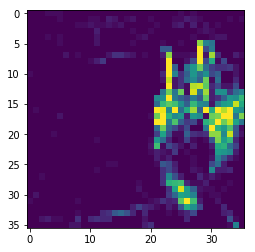

In [12]:
i = 19993
plt.imshow(x_all[i, :, :, 0].transpose())
print(np.argmax(y_all[i]))
print(label_dict)

In [22]:
x_all.shape

(230378, 36, 36, 1)

(array([ 121462.,       0.,       0.,   25982.,       0.,       0.,
          41812.,       0.,       0.,   41122.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

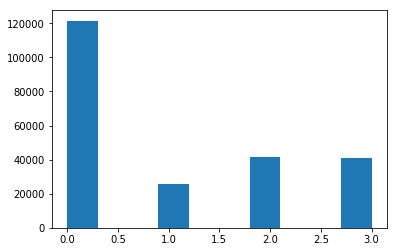

In [33]:
plt.hist(np.argmax(y_all, -1))

(0, 100)

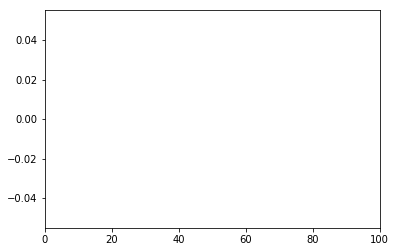

In [13]:
plt.hist(x_all[x_all.nonzero()], 1000);
plt.xlim(0, 100)